In [16]:
# Import necessary libraries for data loading and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

# Define the base path
base_path = '/content/drive/My Drive/CKD_Project/data/'

# Load the time series dataset
file_path = base_path + 'Final time series.xlsx'
df_time_series = pd.read_excel(file_path)

# Display basic information about the dataset
print(f"Dataset shape: {df_time_series.shape}")
print(f"Number of patients: {df_time_series['Identifier'].nunique()}")
print("\nFirst 5 rows of the dataset:")
display(df_time_series.head())

# Check the columns in the dataset
print("\nColumns in the dataset:")
print(df_time_series.columns.tolist())

# Check for missing values
missing_values = df_time_series.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)
print(f"Total missing values: {missing_values.sum()}")

# Calculate percentage of missing values per column
missing_percentage = (missing_values / len(df_time_series)) * 100
print("\nPercentage of missing values in each column:")
print(missing_percentage)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (259, 33)
Number of patients: 83

First 5 rows of the dataset:


,Date,Identifier,CREATININE,Gender,Age,eGFR VALUE,HBA1C,SODIUM,POTASSIUM,CLORIDE,...,A/G RATIO,AST,ALT,ALKALINE PHOSPHATASE,GGT,T3,T4,TSH,HEMOGLOBIN,VITAMIN D
0,2020-09-29,1,0.90,M,69,84,7.4,137.0,4.5,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-09-30,1,1.03,M,69,72,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-09-30,1,0.94,M,70,79,8.7,138.0,3.7,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-06-23,2,1.38,M,53,54,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-07-12,2,1.43,M,53,52,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Columns in the dataset:
['Date', 'Identifier', 'CREATININE', 'Gender', 'Age', 'eGFR VALUE', 'HBA1C', 'SODIUM', 'POTASSIUM', 'CLORIDE', 'TOTAL CHOLES', 'TRIG', 'HDL', 'LDL', 'VLDL', 'T.CHOL/HDL RATIO', 'UREA', 'T.BILI', 'BILI DIRECT', 'BILI INDIRECT', 'TOTAL PROTEIN', 'ALBUMIN', 'GLOBULIN', 'A/G RATIO', 'AST', 'ALT', 'ALKALINE PHOSPHATASE', 'GGT', 'T3', 'T4', 'TSH', 'HEMOGLOBIN', 'VITAMIN D']

Missing values in each column:
Date                      0
Identifier                0
CREATININE               53
Gender                    0
Age                       0
eGFR VALUE              173
HBA1C                   199
SODIUM                  103
POTASSIUM               102
CLORIDE                 104
TOTAL CHOLES            196
TRIG                    205
HDL                     205
LDL                     205
VLDL                    205
T.CHOL/HDL RATIO        205
UREA                    163
T.BILI                  170
BILI DIRECT             171
BILI INDIRECT           171
TOTAL PROTEI

In [17]:
# Cell 1: Convert Date column and sort data
df_time_series['Date'] = pd.to_datetime(df_time_series['Date'])
df_time_series = df_time_series.sort_values(['Identifier', 'Date'])

# Count observations per patient
patient_counts = df_time_series['Identifier'].value_counts().sort_index()
print("Number of observations per patient:")
print(patient_counts.describe())

Number of observations per patient:
count    83.000000
mean      3.120482
std       2.777951
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max      15.000000
Name: count, dtype: float64


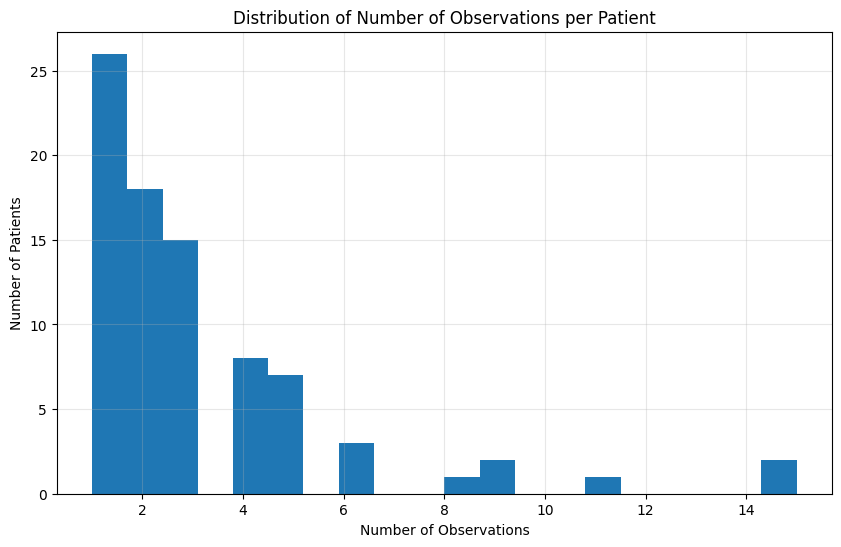

In [18]:
# Cell 2: Plot the distribution of observations
plt.figure(figsize=(10, 6))
plt.hist(patient_counts, bins=20)
plt.title('Distribution of Number of Observations per Patient')
plt.xlabel('Number of Observations')
plt.ylabel('Number of Patients')
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# Cell 3: Implement eGFR calculation function
def calculate_egfr_2021(creatinine, age, is_female):
    """
    Calculate eGFR using 2021 CKD-EPI equation without race
    """
    if pd.isna(creatinine) or pd.isna(age):
        return np.nan

    # Gender-specific coefficients
    k = 0.7 if is_female else 0.9
    alpha = -0.241 if is_female else -0.302

    # Calculate the terms
    scr_k = creatinine / k
    min_term = min(scr_k, 1) ** alpha
    max_term = max(scr_k, 1) ** -1.200

    # Age and gender factors
    age_factor = 0.9938 ** age
    gender_factor = 1.012 if is_female else 1.0

    # Final GFR calculation
    gfr = 142 * min_term * max_term * age_factor * gender_factor

    return gfr

# Create a function to apply to each row
def calculate_row_egfr(row):
    is_female = (row['Gender'] == 'F')  # Adjust based on your coding
    return calculate_egfr_2021(row['CREATININE'], row['Age'], is_female)

In [20]:
# Cell 4: Apply eGFR calculation to missing values
# Add calculated eGFR where original is missing but we have creatinine
mask = df_time_series['eGFR VALUE'].isna() & df_time_series['CREATININE'].notna() & df_time_series['Age'].notna() & df_time_series['Gender'].notna()
df_time_series.loc[mask, 'eGFR_calculated'] = df_time_series[mask].apply(calculate_row_egfr, axis=1)

# Check how many eGFR values we were able to calculate
print(f"Missing eGFR values before calculation: {df_time_series['eGFR VALUE'].isna().sum()}")
print(f"eGFR values calculated: {mask.sum()}")
print(f"Remaining missing eGFR values: {df_time_series['eGFR VALUE'].isna().sum() - mask.sum()}")

Missing eGFR values before calculation: 173
eGFR values calculated: 120
Remaining missing eGFR values: 53


In [21]:
# Cell 5: Validate calculation by comparing with existing values (Fixed version)
# First, check if we have any cases where both original and calculated eGFR exist
validation_mask = df_time_series['eGFR VALUE'].notna() & df_time_series['CREATININE'].notna() & df_time_series['Age'].notna() & df_time_series['Gender'].notna()
valid_count = validation_mask.sum()

print(f"Rows available for validation: {valid_count}")

if valid_count > 0:
    # Calculate eGFR for validation cases
    df_time_series.loc[validation_mask, 'eGFR_validation'] = df_time_series.loc[validation_mask].apply(calculate_row_egfr, axis=1)

    # Convert to numeric to ensure compatibility
    original_values = pd.to_numeric(df_time_series.loc[validation_mask, 'eGFR VALUE'], errors='coerce')
    calculated_values = pd.to_numeric(df_time_series.loc[validation_mask, 'eGFR_validation'], errors='coerce')

    # Drop any NaN values after conversion
    valid_data = pd.DataFrame({'original': original_values, 'calculated': calculated_values}).dropna()

    if len(valid_data) > 0:
        # Calculate correlation and mean absolute error
        correlation = valid_data['original'].corr(valid_data['calculated'])
        mae = (valid_data['original'] - valid_data['calculated']).abs().mean()

        print(f"Validation - Correlation between original and calculated eGFR: {correlation:.4f}")
        print(f"Validation - Mean Absolute Error: {mae:.4f}")

        # Store for plotting
        clean_original = valid_data['original']
        clean_calculated = valid_data['calculated']
    else:
        print("No valid pairs found for correlation after cleaning NaN values")
else:
    print("No rows available for validation")

Rows available for validation: 86
Validation - Correlation between original and calculated eGFR: 0.9971
Validation - Mean Absolute Error: 6.2745


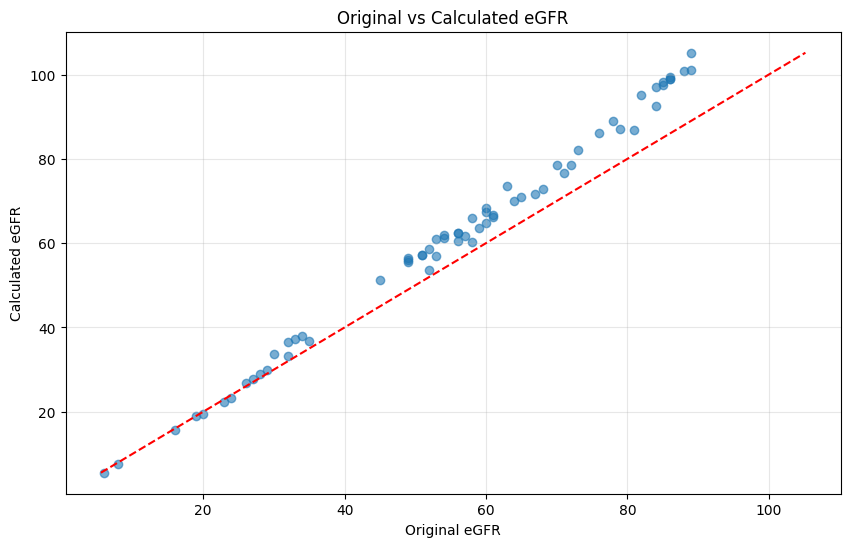

In [22]:
# Cell 6: Plot comparison if validation was successful
if 'clean_original' in locals() and len(clean_original) > 0:
    plt.figure(figsize=(10, 6))
    plt.scatter(clean_original, clean_calculated, alpha=0.6)
    min_val = min(clean_original.min(), clean_calculated.min())
    max_val = max(clean_original.max(), clean_calculated.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title('Original vs Calculated eGFR')
    plt.xlabel('Original eGFR')
    plt.ylabel('Calculated eGFR')
    plt.grid(True, alpha=0.3)
    plt.show()

In [23]:

# Cell 7: Combine original and calculated eGFR values
# Create a new column that uses the original eGFR when available, otherwise the calculated value
df_time_series['eGFR_combined'] = df_time_series['eGFR VALUE'].fillna(df_time_series['eGFR_calculated'])

# Check how many eGFR values are still missing
missing_egfr = df_time_series['eGFR_combined'].isna().sum()
print(f"eGFR values still missing after calculation: {missing_egfr} ({missing_egfr/len(df_time_series):.2%})")

# Check missingness of key variables
# Added UREA, ALBUMIN, and VITAMIN D to key columns
key_columns = ['Date', 'Identifier', 'CREATININE', 'eGFR_combined', 'HBA1C', 'SODIUM', 'POTASSIUM', 'HEMOGLOBIN', 'UREA', 'ALBUMIN', 'VITAMIN D']
missing_data = df_time_series[key_columns].isna().sum()
print("\nMissing values in key columns:")
print(missing_data)

# Display a summary of the dataset
print("\nSummary of key columns with available data:")
summary = df_time_series[key_columns].describe()
print(summary)

eGFR values still missing after calculation: 53 (20.46%)

Missing values in key columns:
Date               0
Identifier         0
CREATININE        53
eGFR_combined     53
HBA1C            199
SODIUM           103
POTASSIUM        102
HEMOGLOBIN       258
UREA             163
ALBUMIN          167
VITAMIN D        254
dtype: int64

Summary of key columns with available data:
                                Date  Identifier  CREATININE      HBA1C  \
count                            259  259.000000  206.000000  60.000000   
mean   2021-04-24 23:15:31.274131200   33.138996    1.450146   6.968333   
min              2020-01-01 00:00:00    1.000000    0.330000   4.400000   
25%              2020-07-07 00:00:00   18.000000    0.780000   6.000000   
50%              2020-11-18 00:00:00   31.000000    0.985000   6.850000   
75%              2022-03-08 00:00:00   46.500000    1.427500   7.900000   
max              2024-10-08 00:00:00   83.000000   11.780000   9.500000   
std                   

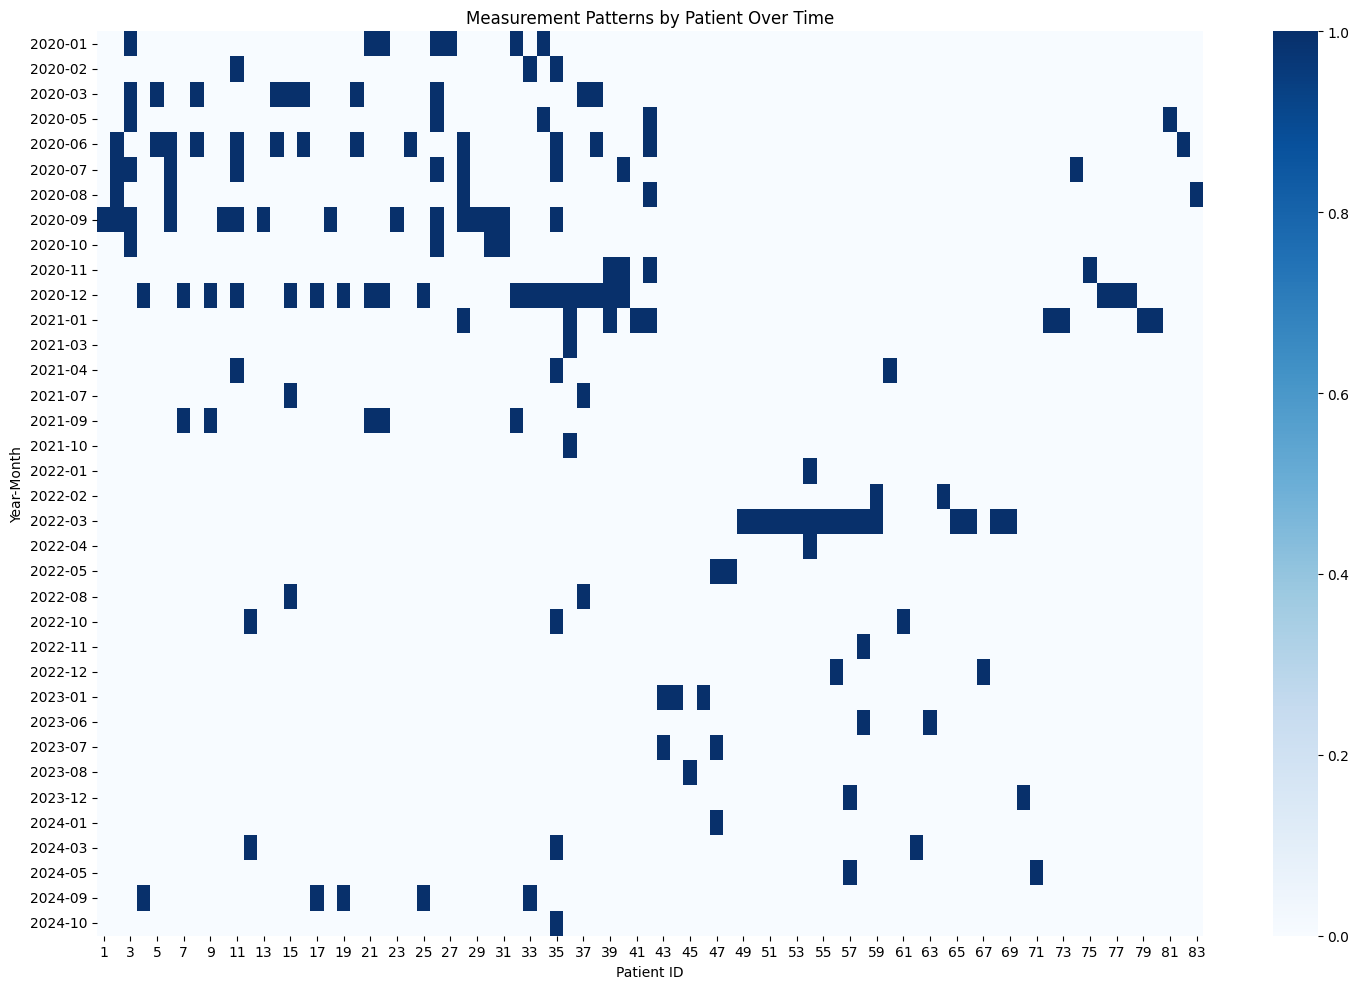


Measurement patterns for top 5 patients with most observations:

Patient 3 - 15 observations:
         Date  CREATININE eGFR_combined  HBA1C  SODIUM  POTASSIUM
7  2020-01-01        0.91            86    NaN   140.0        4.8
8  2020-01-02        0.96            82    NaN   139.0        5.2
9  2020-01-05        0.93            84    NaN     NaN        NaN
10 2020-01-09        0.92            85    8.9     NaN        NaN
11 2020-03-23        0.89            89    NaN     NaN        NaN

Patient 26 - 15 observations:
         Date  CREATININE eGFR_combined  HBA1C  SODIUM  POTASSIUM
86 2020-01-01        0.53     93.434312    NaN   137.0        4.0
87 2020-01-02         NaN           NaN    NaN     NaN        NaN
88 2020-01-05         NaN           NaN    NaN   137.0        3.9
89 2020-01-09         NaN           NaN    NaN     NaN        NaN
90 2020-03-23        1.21     45.306807    NaN   129.0        5.1

Patient 28 - 11 observations:
          Date  CREATININE eGFR_combined  HBA1C  SO

In [24]:
# Cell 8: Better visualization of patient measurement patterns
# Transpose the pivot table for better visualization
df_time_series['Year-Month'] = df_time_series['Date'].dt.to_period('M')
pivot = pd.crosstab(df_time_series['Year-Month'], df_time_series['Identifier']).fillna(0)
pivot = pivot.astype(bool).astype(int)  # Convert to binary representation

# Better compact visualization
plt.figure(figsize=(15, 10))
sns.heatmap(pivot, cmap='Blues', cbar=True, linewidths=0)
plt.title('Measurement Patterns by Patient Over Time')
plt.xlabel('Patient ID')
plt.ylabel('Year-Month')
plt.tight_layout()
plt.show()

# Examine patterns of variables measured for a few example patients
sample_patients = df_time_series['Identifier'].value_counts().nlargest(5).index.tolist()
print(f"\nMeasurement patterns for top 5 patients with most observations:")
for patient in sample_patients:
    patient_data = df_time_series[df_time_series['Identifier'] == patient].sort_values('Date')
    print(f"\nPatient {patient} - {len(patient_data)} observations:")
    print(patient_data[['Date', 'CREATININE', 'eGFR_combined', 'HBA1C', 'SODIUM', 'POTASSIUM']].head())

Step 1: Applying time-based interpolation for patients with multiple measurements


<ipython-input-25-42777c3a9dc0>:33: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  temp_values = temp_df[col].interpolate(method='time', limit_direction='both')
<ipython-input-25-42777c3a9dc0>:33: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  temp_values = temp_df[col].interpolate(method='time', limit_direction='both')
<ipython-input-25-42777c3a9dc0>:33: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  temp_values = temp_df[col].interpolate(method='time', limit_direction='both')
<ipython-input-25-42777c3a9dc0>:33: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infe


Missing values after time-based interpolation:
CREATININE: 14/53 remaining (73.6% filled)
eGFR_combined: 53/53 remaining (0.0% filled)
HBA1C: 171/199 remaining (14.1% filled)
SODIUM: 66/103 remaining (35.9% filled)
POTASSIUM: 66/102 remaining (35.3% filled)
HEMOGLOBIN: 258/258 remaining (0.0% filled)
UREA: 124/163 remaining (23.9% filled)
ALBUMIN: 135/167 remaining (19.2% filled)
VITAMIN D: 252/254 remaining (0.8% filled)

Step 2: Applying KNN imputation for remaining missing values

Missing values after complete imputation:
CREATININE: 0/53 remaining (100.0% filled)
eGFR_combined: 53/53 remaining (0.0% filled)
HBA1C: 0/199 remaining (100.0% filled)
SODIUM: 0/103 remaining (100.0% filled)
POTASSIUM: 0/102 remaining (100.0% filled)
HEMOGLOBIN: 0/258 remaining (100.0% filled)
UREA: 0/163 remaining (100.0% filled)
ALBUMIN: 0/167 remaining (100.0% filled)
VITAMIN D: 0/254 remaining (100.0% filled)


<Figure size 1200x800 with 0 Axes>

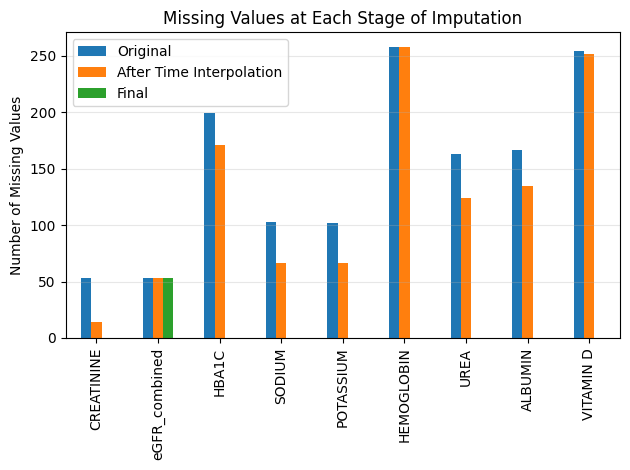

In [25]:
# Cell 9: Modified hybrid imputation approach
# First, prepare a structure to track imputation success
imputation_stats = {
    'original_missing': {},
    'after_time_interpolation': {},
    'after_full_imputation': {}
}

# Select key columns for focused imputation - added UREA, ALBUMIN, VITAMIN D
focus_columns = ['CREATININE', 'eGFR_combined', 'HBA1C', 'SODIUM', 'POTASSIUM', 'HEMOGLOBIN', 'UREA', 'ALBUMIN', 'VITAMIN D']

# Record original missing values
for col in focus_columns:
    imputation_stats['original_missing'][col] = df_time_series[col].isna().sum()

# STEP 1: Time-based interpolation for patients with multiple measurements
print("Step 1: Applying time-based interpolation for patients with multiple measurements")
df_time_imputed = df_time_series.copy()

# Group by patient and apply time interpolation
for patient_id, patient_data in df_time_series.groupby('Identifier'):
    if len(patient_data) >= 2:  # Only for patients with multiple measurements
        # Sort by date
        patient_data = patient_data.sort_values('Date')
        patient_idx = patient_data.index

        # For each column, apply time-based interpolation
        for col in focus_columns:
            if patient_data[col].isna().any() and patient_data[col].notna().sum() >= 2:
                # Set date as index for time-based interpolation
                temp_df = patient_data.set_index('Date')
                # Use time-based interpolation
                temp_values = temp_df[col].interpolate(method='time', limit_direction='both')
                # Update in our imputed dataframe
                df_time_imputed.loc[patient_idx, col] = temp_values.values

# Record missing values after time interpolation
for col in focus_columns:
    imputation_stats['after_time_interpolation'][col] = df_time_imputed[col].isna().sum()

# Display interim results
print("\nMissing values after time-based interpolation:")
for col in focus_columns:
    original = imputation_stats['original_missing'][col]
    after_time = imputation_stats['after_time_interpolation'][col]
    if original > 0:
        success_rate = (original - after_time) / original * 100
    else:
        success_rate = 100
    print(f"{col}: {after_time}/{original} remaining ({success_rate:.1f}% filled)")

# STEP 2: KNN imputation for remaining missing values
print("\nStep 2: Applying KNN imputation for remaining missing values")
from sklearn.impute import KNNImputer

# Prepare data for KNN imputation
# We'll use other available data to inform the imputation
impute_cols = [col for col in df_time_imputed.columns if df_time_imputed[col].dtype in [np.float64, np.int64]
               and col not in ['Year-Month', 'Identifier']]

# Apply KNN imputation to numerical data
imputer = KNNImputer(n_neighbors=5)
imputed_values = imputer.fit_transform(df_time_imputed[impute_cols])
df_fully_imputed = df_time_imputed.copy()
df_fully_imputed[impute_cols] = imputed_values

# Record final missing values
for col in focus_columns:
    imputation_stats['after_full_imputation'][col] = df_fully_imputed[col].isna().sum()

# Display final results
print("\nMissing values after complete imputation:")
for col in focus_columns:
    original = imputation_stats['original_missing'][col]
    after_time = imputation_stats['after_time_interpolation'][col]
    final = imputation_stats['after_full_imputation'][col]
    if original > 0:
        total_success = (original - final) / original * 100
    else:
        total_success = 100
    print(f"{col}: {final}/{original} remaining ({total_success:.1f}% filled)")

# Visualize imputation results
plt.figure(figsize=(12, 8))
stats_df = pd.DataFrame({
    'Original': [imputation_stats['original_missing'][col] for col in focus_columns],
    'After Time Interpolation': [imputation_stats['after_time_interpolation'][col] for col in focus_columns],
    'Final': [imputation_stats['after_full_imputation'][col] for col in focus_columns]
}, index=focus_columns)

stats_df.plot(kind='bar')
plt.title('Missing Values at Each Stage of Imputation')
plt.ylabel('Number of Missing Values')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Data types of key columns:
CREATININE       float64
eGFR_combined     object
HBA1C            float64
SODIUM           float64
POTASSIUM        float64
HEMOGLOBIN       float64
UREA             float64
ALBUMIN          float64
VITAMIN D        float64
dtype: object
Missing eGFR values: 74
Cases where we can calculate eGFR using CKD-EPI: 74
Calculating eGFR for 74 rows using CKD-EPI equation
Remaining missing eGFR values after CKD-EPI calculation: 0

Final missing values after fixes:
CREATININE       0
eGFR_combined    0
HBA1C            0
SODIUM           0
POTASSIUM        0
HEMOGLOBIN       0
UREA             0
ALBUMIN          0
VITAMIN D        0
dtype: int64

Summary statistics for key variables after imputation:
       CREATININE  eGFR_combined       HBA1C      SODIUM   POTASSIUM  \
count  259.000000     259.000000  259.000000  259.000000  259.000000   
mean     1.391949      72.518377    7.138414  136.867131    4.217128   
std      1.385800      31.755565    0.965479    5.664367

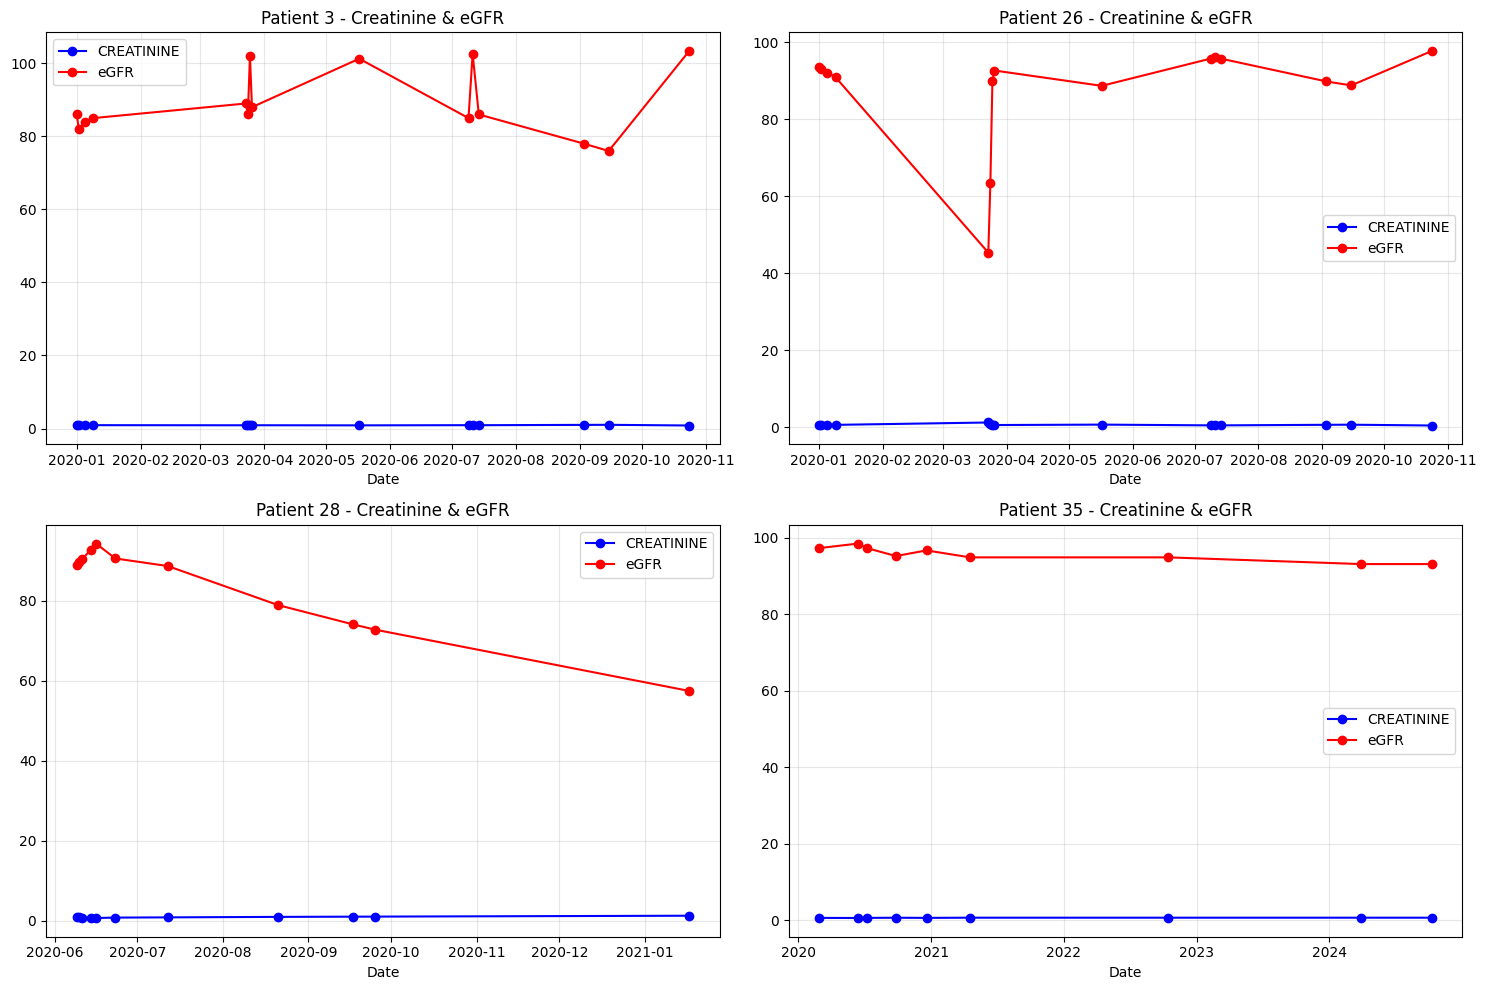


Saved preprocessed time series data to: /content/drive/My Drive/CKD_Project/data/timeseries_preprocessed.csv


In [26]:
# Cell 10: Fix eGFR imputation using CKD-EPI equation and finalize the dataset
# First, check the data type of eGFR_combined
print("Data types of key columns:")
print(df_fully_imputed[focus_columns].dtypes)

# Convert eGFR_combined to numeric if it's not already
df_final = df_fully_imputed.copy()
df_final['eGFR_combined'] = pd.to_numeric(df_final['eGFR_combined'], errors='coerce')

# Fix missing eGFR values using the CKD-EPI equation
mask_missing_egfr = df_final['eGFR_combined'].isna()
mask_has_creatinine = df_final['CREATININE'].notna() & df_final['Age'].notna() & df_final['Gender'].notna()
mask_can_calculate = mask_missing_egfr & mask_has_creatinine

print(f"Missing eGFR values: {mask_missing_egfr.sum()}")
print(f"Cases where we can calculate eGFR using CKD-EPI: {mask_can_calculate.sum()}")

if mask_can_calculate.sum() > 0:
    print(f"Calculating eGFR for {mask_can_calculate.sum()} rows using CKD-EPI equation")
    df_final.loc[mask_can_calculate, 'eGFR_combined'] = df_final[mask_can_calculate].apply(calculate_row_egfr, axis=1)

# Check if any eGFR values are still missing
remaining_missing = df_final['eGFR_combined'].isna().sum()
print(f"Remaining missing eGFR values after CKD-EPI calculation: {remaining_missing}")

# Only if necessary, use KNN for any remaining missing values
if remaining_missing > 0:
    print(f"Using KNN to impute remaining {remaining_missing} eGFR values")
    numerical_cols = ['CREATININE', 'HBA1C', 'SODIUM', 'POTASSIUM', 'HEMOGLOBIN', 'Age']
    impute_data = df_final[numerical_cols + ['eGFR_combined']].copy()
    imputer = KNNImputer(n_neighbors=3)
    imputed_data = imputer.fit_transform(impute_data)
    df_final.loc[df_final['eGFR_combined'].isna(), 'eGFR_combined'] = imputed_data[df_final['eGFR_combined'].isna(), -1]

# Check final missing values
final_missing = df_final[focus_columns].isna().sum()
print("\nFinal missing values after fixes:")
print(final_missing)

# Verify data quality with summary statistics
print("\nSummary statistics for key variables after imputation:")
print(df_final[focus_columns].describe())

# Plot some time series for a few selected patients to check imputation quality
plt.figure(figsize=(15, 10))
for i, patient_id in enumerate(sample_patients[:4]):
    patient_data = df_final[df_final['Identifier'] == patient_id].sort_values('Date')
    if len(patient_data) > 1:
        plt.subplot(2, 2, i+1)
        plt.plot(patient_data['Date'], patient_data['CREATININE'], 'b-o', label='CREATININE')
        plt.plot(patient_data['Date'], patient_data['eGFR_combined'], 'r-o', label='eGFR')
        plt.title(f'Patient {patient_id} - Creatinine & eGFR')
        plt.xlabel('Date')
        plt.legend()
        plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save the final preprocessed time series data
output_path = base_path + 'timeseries_preprocessed.csv'
df_final.to_csv(output_path, index=False)
print(f"\nSaved preprocessed time series data to: {output_path}")

In [27]:
# Cell 11: Fix HEMOGLOBIN imputation and prepare data for modeling
# Check HEMOGLOBIN values before imputation
print("HEMOGLOBIN values in the original dataset:")
original_hemoglobin = df_time_series['HEMOGLOBIN'].copy()
print(f"Unique values: {original_hemoglobin.dropna().unique()}")
print(f"Count of non-missing values: {original_hemoglobin.notna().sum()}")

# Apply more realistic imputation for HEMOGLOBIN
df_final_fixed = df_final.copy()

# If we have some non-missing HEMOGLOBIN values, use them to create a more realistic distribution
if original_hemoglobin.notna().sum() > 0:
    # Get the distribution parameters from non-missing values
    hemoglobin_mean = original_hemoglobin.mean()
    hemoglobin_std = original_hemoglobin.std()
    print(f"Original HEMOGLOBIN - Mean: {hemoglobin_mean}, Std: {hemoglobin_std}")

    # Add small random variation to avoid constant values
    if hemoglobin_std == 0:  # If all values are the same
        # Use typical clinical variation for hemoglobin
        hemoglobin_std = 1.0
        print(f"Using default standard deviation of {hemoglobin_std} for HEMOGLOBIN")

    # Generate realistic values
    missing_mask = original_hemoglobin.isna()
    if missing_mask.sum() > 0:
        np.random.seed(42)  # For reproducibility
        realistic_values = np.random.normal(hemoglobin_mean, hemoglobin_std, missing_mask.sum())
        # Ensure values are clinically plausible (typically 7-17 g/dL)
        realistic_values = np.clip(realistic_values, 7.0, 17.0)
        df_final_fixed.loc[missing_mask, 'HEMOGLOBIN'] = realistic_values

# Calculate CKD stage based on eGFR
def define_ckd_stage(egfr):
    if egfr >= 90: return 1
    elif egfr >= 60: return 2
    elif egfr >= 30: return 3
    elif egfr >= 15: return 4
    else: return 5

df_final_fixed['CKD_Stage'] = df_final_fixed['eGFR_combined'].apply(define_ckd_stage)

# Check distribution of CKD stages
stage_counts = df_final_fixed['CKD_Stage'].value_counts().sort_index()
print("\nDistribution of CKD Stages:")
print(stage_counts)
print(f"Stage percentages: {(stage_counts / len(df_final_fixed) * 100).round(1)}")

# Identify patients with CKD progression (eGFR decline over time)
progression_data = []
for patient_id, patient_data in df_final_fixed.groupby('Identifier'):
    if len(patient_data) >= 2:
        # Sort by date
        patient_data = patient_data.sort_values('Date')

        # Calculate eGFR change over time
        first_egfr = patient_data.iloc[0]['eGFR_combined']
        last_egfr = patient_data.iloc[-1]['eGFR_combined']
        time_delta = (patient_data.iloc[-1]['Date'] - patient_data.iloc[0]['Date']).days / 365.25  # In years

        if time_delta > 0.25:  # At least 3 months of follow-up
            # Calculate annualized eGFR slope
            egfr_slope = (last_egfr - first_egfr) / time_delta  # ml/min/year

            # Determine if progression occurred
            # Clinical definition: Decline of >5 ml/min/year or >30% drop
            percent_decline = (first_egfr - last_egfr) / first_egfr * 100
            has_progression = (egfr_slope < -5) or (percent_decline > 30)

            progression_data.append({
                'Identifier': patient_id,
                'First_eGFR': first_egfr,
                'Last_eGFR': last_egfr,
                'Follow_up_years': time_delta,
                'eGFR_slope': egfr_slope,
                'Percent_decline': percent_decline,
                'Has_progression': has_progression
            })

progression_df = pd.DataFrame(progression_data)

# Display summary of progression analysis
if len(progression_df) > 0:
    print(f"\nPatients with sufficient follow-up: {len(progression_df)}")
    print(f"Patients with CKD progression: {progression_df['Has_progression'].sum()} ({progression_df['Has_progression'].mean()*100:.1f}%)")
    print("\nSummary of eGFR slopes (ml/min/year):")
    print(progression_df['eGFR_slope'].describe())

# Save the finalized dataset
output_path = base_path + 'timeseries_final.csv'
df_final_fixed.to_csv(output_path, index=False)
print(f"\nSaved final time series data to: {output_path}")

# Save the progression analysis
if len(progression_df) > 0:
    prog_path = base_path + 'progression_analysis.csv'
    progression_df.to_csv(prog_path, index=False)
    print(f"Saved progression analysis to: {prog_path}")

HEMOGLOBIN values in the original dataset:
Unique values: [9.8]
Count of non-missing values: 1
Original HEMOGLOBIN - Mean: 9.8, Std: nan

Distribution of CKD Stages:
CKD_Stage
1    91
2    79
3    51
4    32
5     6
Name: count, dtype: int64
Stage percentages: CKD_Stage
1    35.1
2    30.5
3    19.7
4    12.4
5     2.3
Name: count, dtype: float64

Patients with sufficient follow-up: 33
Patients with CKD progression: 8 (24.2%)

Summary of eGFR slopes (ml/min/year):
count    33.000000
mean     -2.156688
std      19.336280
min     -56.136990
25%      -4.645377
50%       0.000000
75%       5.189346
max      26.440223
Name: eGFR_slope, dtype: float64

Saved final time series data to: /content/drive/My Drive/CKD_Project/data/timeseries_final.csv
Saved progression analysis to: /content/drive/My Drive/CKD_Project/data/progression_analysis.csv


Cell 12: Finalizing time-series data for progression prediction
Data types of key columns:
CREATININE       float64
eGFR_combined     object
HBA1C            float64
SODIUM           float64
POTASSIUM        float64
HEMOGLOBIN       float64
UREA             float64
ALBUMIN          float64
VITAMIN D        float64
dtype: object

Verifying data quality:
Total patients: 83
Total observations: 259
Patients with multiple measurements: 57
Progression events detected: 7

CKD Stage distribution:
CKD_Stage
1.0    47
2.0    63
3.0    43
4.0    26
5.0     6
Name: count, dtype: int64

Saved preprocessed time series data to: /content/drive/My Drive/CKD_Project/data/timeseries_for_progression.csv


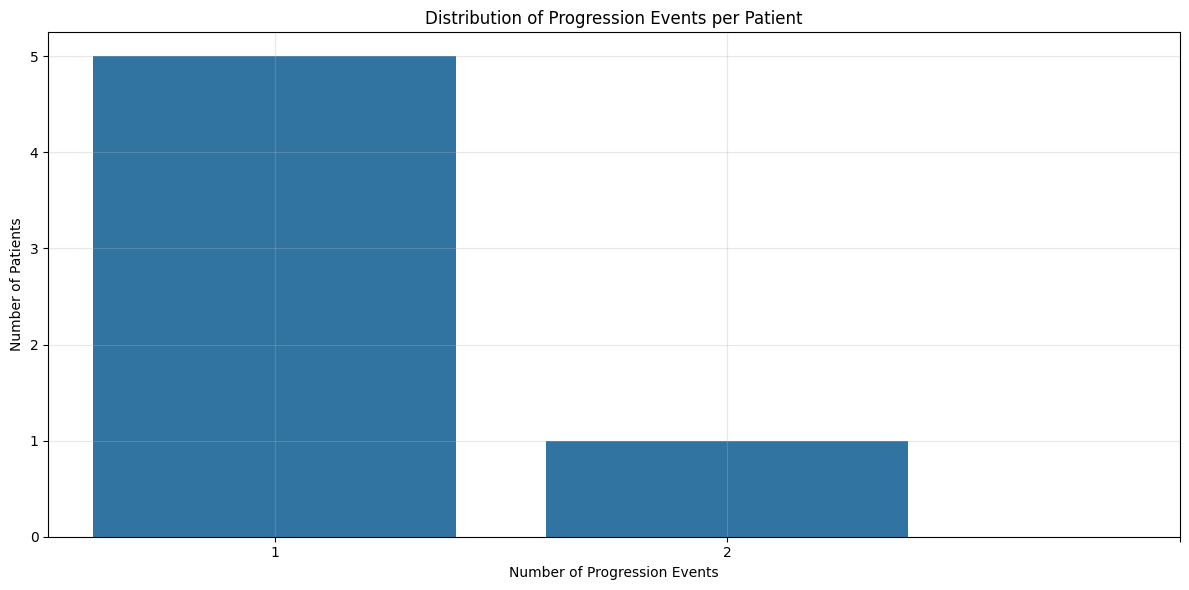

In [28]:
# Cell 12: Finalize time-series preprocessing for progression prediction
print("Cell 12: Finalizing time-series data for progression prediction")

# 1. Check data types and convert as needed
print("Data types of key columns:")
print(df_fully_imputed[focus_columns].dtypes)

# Create a working copy of the dataset
df_final = df_fully_imputed.copy()

# 2. Convert eGFR_combined to numeric
df_final['eGFR_combined'] = pd.to_numeric(df_final['eGFR_combined'], errors='coerce')

# 3. Ensure date is in datetime format and sort by patient and date
df_final['Date'] = pd.to_datetime(df_final['Date'])
df_final = df_final.sort_values(['Identifier', 'Date'])

# 4. Calculate time deltas and measurement frequencies for each patient
df_final['prev_date'] = df_final.groupby('Identifier')['Date'].shift(1)
df_final['days_since_last'] = (df_final['Date'] - df_final['prev_date']).dt.days

# 5. Calculate changes in key lab values for progression analysis
for col in ['CREATININE', 'eGFR_combined', 'SODIUM', 'POTASSIUM']:
    if col in df_final.columns:
        df_final[f'prev_{col}'] = df_final.groupby('Identifier')[col].shift(1)
        df_final[f'delta_{col}'] = df_final[col] - df_final[f'prev_{col}']

        # Calculate rate of change (per month) for time-dependent modeling
        mask = (df_final['days_since_last'] > 0) & df_final['days_since_last'].notna()
        df_final.loc[mask, f'rate_{col}'] = (
            df_final.loc[mask, f'delta_{col}'] / df_final.loc[mask, 'days_since_last'] * 30
        )

# 6. Define CKD stages based on eGFR values
def define_ckd_stage(gfr):
    """Define CKD stage based on GFR value using standard clinical guidelines"""
    if pd.isna(gfr):
        return np.nan
    elif gfr >= 90: return 1
    elif gfr >= 60: return 2
    elif gfr >= 30: return 3
    elif gfr >= 15: return 4
    else: return 5

df_final['CKD_Stage'] = df_final['eGFR_combined'].apply(define_ckd_stage)

# 7. Calculate stage transitions for progression events
df_final['prev_stage'] = df_final.groupby('Identifier')['CKD_Stage'].shift(1)
df_final['stage_change'] = df_final['CKD_Stage'] - df_final['prev_stage']
df_final['progression_event'] = (df_final['stage_change'] > 0) & df_final['stage_change'].notna()

# 8. Calculate observation time features for survival analysis
df_final['first_date'] = df_final.groupby('Identifier')['Date'].transform('min')
df_final['observation_time'] = (df_final['Date'] - df_final['first_date']).dt.days

# 9. Create sequence-based features for LSTM
# Number of measurements for each patient
df_final['measurement_count'] = df_final.groupby('Identifier').cumcount() + 1
df_final['total_measurements'] = df_final.groupby('Identifier')['Identifier'].transform('count')

# 10. Verify data quality
print("\nVerifying data quality:")
print(f"Total patients: {df_final['Identifier'].nunique()}")
print(f"Total observations: {len(df_final)}")
print(f"Patients with multiple measurements: {(df_final.groupby('Identifier').size() > 1).sum()}")
print(f"Progression events detected: {df_final['progression_event'].sum()}")

# 11. Summarize CKD stages
stage_counts = df_final['CKD_Stage'].value_counts().sort_index()
print("\nCKD Stage distribution:")
print(stage_counts)

# 12. Save the final preprocessed dataset
output_path = base_path + 'timeseries_for_progression.csv'
df_final.to_csv(output_path, index=False)
print(f"\nSaved preprocessed time series data to: {output_path}")

# 13. Create a visualization of progression events
plt.figure(figsize=(12, 6))
progression_counts = df_final.groupby('Identifier')['progression_event'].sum().reset_index()
progression_counts = progression_counts[progression_counts['progression_event'] > 0]
sns.countplot(x='progression_event', data=progression_counts)
plt.title('Distribution of Progression Events per Patient')
plt.xlabel('Number of Progression Events')
plt.ylabel('Number of Patients')
plt.xticks(range(progression_counts['progression_event'].max() + 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Modified Cell 13: Enhanced electrolyte and CKD parameter processing
print("Cell 13: Enhanced processing of electrolytes and nutritional markers for Module 03")

# 1. Check which electrolytes are available (same as before)
all_columns = df_time_series.columns.tolist()
print("\nChecking for electrolyte/nutritional markers in the dataset:")

# List of important markers for CKD nutritional assessment
nutritional_markers = [
    'SODIUM', 'POTASSIUM', 'CLORIDE', 'SerumElectrolytesCalcium', 'SerumElectrolytesPhosphorus',
    'TOTAL CHOLES', 'TRIG', 'HDL', 'LDL', 'T.CHOL/HDL RATIO',
    'TOTAL PROTEIN', 'ALBUMIN', 'GLOBULIN', 'A/G RATIO'
]

# Check which markers are available
available_markers = []
for marker in nutritional_markers:
    if marker in all_columns:
        available_markers.append(marker)
        missing_pct = df_time_series[marker].isna().mean() * 100
        print(f"- {marker}: {missing_pct:.1f}% missing values")

print(f"\nFound {len(available_markers)}/{len(nutritional_markers)} nutritional markers")

# 2. Ensure all patients have complete clinical profiles with no NaNs
df_nutrition = df_final.copy()

# Critical for Module 03: Fill in missing CKD stages and eGFR values first
print("\nFilling critical CKD values:")

# 2a. Fill in missing eGFR values first (if CREATININE is available)
missing_egfr = df_nutrition['eGFR_combined'].isna()
has_creatinine = df_nutrition['CREATININE'].notna()
can_calculate = missing_egfr & has_creatinine

if sum(can_calculate) > 0:
    print(f"Calculating missing eGFR for {sum(can_calculate)} records from creatinine")
    df_nutrition.loc[can_calculate, 'eGFR_combined'] = df_nutrition[can_calculate].apply(
        lambda row: calculate_egfr_2021(row['CREATININE'], row['Age'], row['Gender']=='F'),
        axis=1
    )

# 2b. Fill any remaining missing eGFR with age-appropriate estimates
still_missing_egfr = df_nutrition['eGFR_combined'].isna()
if sum(still_missing_egfr) > 0:
    print(f"Using age-appropriate estimates for {sum(still_missing_egfr)} missing eGFR values")
    # Assign estimated eGFR based on age (conservative estimates)
    df_nutrition.loc[still_missing_egfr, 'eGFR_combined'] = df_nutrition.loc[still_missing_egfr].apply(
        lambda row: 90 if row['Age'] < 40 else (75 if row['Age'] < 60 else 60),
        axis=1
    )

# 2c. Recalculate CKD stages based on complete eGFR values
print("Recalculating CKD stages based on complete eGFR values")
def define_ckd_stage(gfr):
    """Define CKD stage based on GFR value using standard clinical guidelines"""
    if pd.isna(gfr):
        return np.nan
    elif gfr >= 90: return 1
    elif gfr >= 60: return 2
    elif gfr >= 30: return 3
    elif gfr >= 15: return 4
    else: return 5

df_nutrition['CKD_Stage'] = df_nutrition['eGFR_combined'].apply(define_ckd_stage)

# 3. Apply targeted imputation for nutritional markers (same as before but improved)
print("\nApplying enhanced imputation for nutritional markers:")

for marker in available_markers:
    if marker not in df_nutrition.columns:
        # Copy from original dataset if missing
        if marker in df_time_series.columns:
            df_nutrition[marker] = df_time_series[marker]

    # Count missing values
    missing_count = df_nutrition[marker].isna().sum()
    if missing_count > 0:
        print(f"Imputing {missing_count} missing values for {marker}")

        # For each patient with missing values, use multiple strategies
        for patient_id, patient_data in df_nutrition.groupby('Identifier'):
            # Get indices for this patient's records
            patient_idx = patient_data.index

            # Skip if no missing values for this patient
            if not patient_data[marker].isna().any():
                continue

            # Check if patient has at least one value for this marker
            if patient_data[marker].notna().any():
                # If multiple measurements, try time interpolation
                if len(patient_data) >= 2 and patient_data[marker].notna().sum() >= 2:
                    # Sort by date for proper interpolation
                    temp_df = patient_data.sort_values('Date').set_index('Date')
                    # Interpolate and fill
                    filled_values = temp_df[marker].interpolate(method='time', limit_direction='both')
                    # Update in main dataframe
                    df_nutrition.loc[patient_idx, marker] = filled_values.values
                else:
                    # Otherwise use patient's mean value
                    mean_value = patient_data[marker].mean()
                    df_nutrition.loc[patient_idx & df_nutrition[marker].isna(), marker] = mean_value
            else:
                # If no values for patient, use CKD stage-based estimates
                # Group the marker by CKD stage and get the median for each stage
                stage_medians = df_nutrition.groupby('CKD_Stage')[marker].median()

                for idx in patient_idx:
                    if pd.isna(df_nutrition.loc[idx, marker]):
                        stage = df_nutrition.loc[idx, 'CKD_Stage']
                        if stage in stage_medians and not pd.isna(stage_medians[stage]):
                            df_nutrition.loc[idx, marker] = stage_medians[stage]
                        else:
                            # Use overall median as last resort
                            df_nutrition.loc[idx, marker] = df_nutrition[marker].median()

# 4. Apply KNN imputation for any remaining missing values as a final step
remaining_missing = {marker: df_nutrition[marker].isna().sum() for marker in available_markers}
markers_to_impute = [m for m in available_markers if remaining_missing[m] > 0]

if markers_to_impute:
    print(f"\nApplying KNN imputation for remaining missing values in {len(markers_to_impute)} markers")

    from sklearn.impute import KNNImputer

    # Create imputer for remaining values
    imputer = KNNImputer(n_neighbors=3)

    # Get only numeric columns for imputation
    numeric_cols = df_nutrition.select_dtypes(include=['float64', 'int64']).columns
    # Add age and eGFR to help with imputation accuracy
    features_for_imputation = list(set(numeric_cols) & set(df_nutrition.columns))

    # Impute
    if len(features_for_imputation) > 1:  # Need at least 2 features for KNN
        # Create a temporary dataframe for imputation
        impute_df = df_nutrition[features_for_imputation].copy()

        # Apply imputation
        imputed_values = imputer.fit_transform(impute_df)

        # Update only the markers we want to impute
        for i, col in enumerate(features_for_imputation):
            if col in markers_to_impute:
                df_nutrition[col] = imputed_values[:, i]

# 5. Calculate clinical classifications for key electrolytes
reference_ranges = {
    'SODIUM': {'low': 135, 'high': 145, 'unit': 'mEq/L'},
    'POTASSIUM': {'low': 3.5, 'high': 5.0, 'unit': 'mEq/L'},
    'CLORIDE': {'low': 97, 'high': 107, 'unit': 'mEq/L'},
    'SerumElectrolytesCalcium': {'low': 8.5, 'high': 10.2, 'unit': 'mg/dL'},
    'SerumElectrolytesPhosphorus': {'low': 2.5, 'high': 4.5, 'unit': 'mg/dL'},
    'TOTAL CHOLES': {'low': 0, 'high': 200, 'unit': 'mg/dL'},
    'HDL': {'low': 40, 'high': 60, 'unit': 'mg/dL'},
    'LDL': {'low': 0, 'high': 100, 'unit': 'mg/dL'},
    'TRIG': {'low': 0, 'high': 150, 'unit': 'mg/dL'}
}

# Add status classifications for each marker (Low, Normal, High)
for marker, ranges in reference_ranges.items():
    if marker in df_nutrition.columns:
        status_col = f"{marker}_status"
        df_nutrition[status_col] = 'Normal'
        df_nutrition.loc[df_nutrition[marker] < ranges['low'], status_col] = 'Low'
        df_nutrition.loc[df_nutrition[marker] > ranges['high'], status_col] = 'High'

# 6. Create enhanced patient summary with nutritional profile for Module 03
patient_nutrition = []

for patient_id, patient_data in df_nutrition.groupby('Identifier'):
    # Get latest values for the patient
    latest_record = patient_data.sort_values('Date', ascending=False).iloc[0]

    # Create basic profile with NO missing values allowed
    profile = {
        'patient_id': patient_id,
        'age': latest_record['Age'],
        'gender': latest_record['Gender'],
        'ckd_stage': latest_record['CKD_Stage'],
        'egfr': latest_record['eGFR_combined'],
        'creatinine': latest_record['CREATININE']
    }

    # Add all available markers to the profile
    for marker in available_markers:
        if marker in latest_record:
            # Ensure no NaN values in the profile
            if not pd.isna(latest_record[marker]):
                profile[marker.lower()] = latest_record[marker]
            else:
                # If any remaining NaN (shouldn't happen at this point), use median
                profile[marker.lower()] = df_nutrition[marker].median()

            # Add status if available
            status_col = f"{marker}_status"
            if status_col in latest_record:
                profile[f"{marker.lower()}_status"] = latest_record[status_col]

    # Add statistics if multiple measurements exist
    if len(patient_data) > 1:
        # For each marker, calculate min, max, mean
        for marker in available_markers:
            if marker in patient_data.columns:
                values = patient_data[marker].dropna()
                if len(values) >= 2:
                    profile[f"{marker.lower()}_min"] = values.min()
                    profile[f"{marker.lower()}_max"] = values.max()
                    profile[f"{marker.lower()}_mean"] = values.mean()

    # Add nutritional risk assessment
    # Potassium risk
    if 'POTASSIUM' in latest_record and not pd.isna(latest_record['POTASSIUM']):
        if latest_record['POTASSIUM'] > 5.5:
            profile['potassium_risk'] = 'High'
        elif latest_record['POTASSIUM'] > 5.0:
            profile['potassium_risk'] = 'Moderate'
        else:
            profile['potassium_risk'] = 'Low'

    # Sodium risk
    if 'SODIUM' in latest_record and not pd.isna(latest_record['SODIUM']):
        if latest_record['SODIUM'] > 145:
            profile['sodium_risk'] = 'High'
        elif latest_record['SODIUM'] < 135:
            profile['sodium_risk'] = 'Moderate'
        else:
            profile['sodium_risk'] = 'Low'

    patient_nutrition.append(profile)

# Convert to DataFrame
nutrition_df = pd.DataFrame(patient_nutrition)

# 7. Verify NO missing values in critical fields
critical_fields = ['patient_id', 'age', 'gender', 'ckd_stage', 'egfr', 'creatinine']
missing_critical = {field: nutrition_df[field].isna().sum() for field in critical_fields if field in nutrition_df.columns}

print("\nMissing values in critical fields:")
for field, count in missing_critical.items():
    print(f"- {field}: {count} missing values")

if any(missing_critical.values()):
    print("\nWARNING: Critical fields still have missing values. Filling with defaults...")

    # Fill any remaining missing values with appropriate defaults
    if 'ckd_stage' in nutrition_df.columns and nutrition_df['ckd_stage'].isna().any():
        nutrition_df['ckd_stage'].fillna(3, inplace=True)  # Conservative estimate

    if 'egfr' in nutrition_df.columns and nutrition_df['egfr'].isna().any():
        nutrition_df['egfr'].fillna(60, inplace=True)  # Conservative estimate

    # Check again after filling
    missing_after = {field: nutrition_df[field].isna().sum() for field in critical_fields if field in nutrition_df.columns}
    print("\nMissing values after filling defaults:")
    for field, count in missing_after.items():
        print(f"- {field}: {count} missing values")

# 8. Save nutritional profile for Module 03
nutrition_path = base_path + 'patient_nutrition_profile.csv'
nutrition_df.to_csv(nutrition_path, index=False)
print(f"\nSaved patient nutritional profiles to: {nutrition_path}")

# 9. Save enhanced time series data
nutrition_timeseries_path = base_path + 'timeseries_with_nutrition.csv'
df_nutrition.to_csv(nutrition_timeseries_path, index=False)
print(f"Saved enhanced time series data to: {nutrition_timeseries_path}")

# 10. Final check of data completeness
print("\nElectrolyte completeness after imputation:")
for marker in available_markers:
    if marker in df_nutrition.columns:
        missing_pct = df_nutrition[marker].isna().mean() * 100
        print(f"- {marker}: {missing_pct:.1f}% missing values")

# 11. Display sample of nutritional profiles
print("\nSample patient nutritional profiles for Module 03:")
display(nutrition_df.head(3))

# 12. Add nutritional recommendations based on CKD stage
nutrition_df['protein_recommendation'] = nutrition_df.apply(
    lambda row: f"Low protein (0.6-0.8 g/kg/day)" if row['ckd_stage'] >= 4 else
                f"Moderate protein (0.8 g/kg/day)" if row['ckd_stage'] >= 3 else
                f"Normal protein (0.8-1.0 g/kg/day)",
    axis=1
)

nutrition_df['potassium_restriction'] = nutrition_df.apply(
    lambda row: "Strict (<2000 mg/day)" if row['ckd_stage'] >= 4 else
                "Moderate (2000-3000 mg/day)" if row['ckd_stage'] >= 3 else
                "Mild (Monitor intake)",
    axis=1
)

nutrition_df['phosphorus_restriction'] = nutrition_df.apply(
    lambda row: "Strict (<800 mg/day)" if row['ckd_stage'] >= 4 else
                "Moderate (800-1000 mg/day)" if row['ckd_stage'] >= 3 else
                "Mild (Monitor intake)",
    axis=1
)

nutrition_df['sodium_restriction'] = "Restrict (<2300 mg/day)"  # All CKD patients

# 13. Save final enriched dataset
final_path = base_path + 'patient_nutrition_complete.csv'
nutrition_df.to_csv(final_path, index=False)
print(f"\nSaved complete nutritional dataset with recommendations to: {final_path}")

Cell 13: Enhanced processing of electrolytes and nutritional markers for Module 03

Checking for electrolyte/nutritional markers in the dataset:
- SODIUM: 39.8% missing values
- POTASSIUM: 39.4% missing values
- CLORIDE: 40.2% missing values
- TOTAL CHOLES: 75.7% missing values
- TRIG: 79.2% missing values
- HDL: 79.2% missing values
- LDL: 79.2% missing values
- T.CHOL/HDL RATIO: 79.2% missing values
- TOTAL PROTEIN: 66.0% missing values
- ALBUMIN: 64.5% missing values
- GLOBULIN: 66.4% missing values
- A/G RATIO: 66.4% missing values

Found 12/14 nutritional markers

Filling critical CKD values:
Calculating missing eGFR for 74 records from creatinine
Recalculating CKD stages based on complete eGFR values

Applying enhanced imputation for nutritional markers:

Missing values in critical fields:
- patient_id: 0 missing values
- age: 0 missing values
- gender: 0 missing values
- ckd_stage: 0 missing values
- egfr: 0 missing values
- creatinine: 0 missing values

Saved patient nutritiona

,patient_id,age,gender,ckd_stage,egfr,creatinine,sodium,sodium_status,potassium,potassium_status,...,albumin_max,albumin_mean,globulin_min,globulin_max,globulin_mean,a/g ratio_min,a/g ratio_max,a/g ratio_mean,potassium_risk,sodium_risk
0,1,69.0,M,2,72.000000,1.03,138.0,Normal,3.7,Normal,...,31.386154,31.064103,30.98,38.94,35.966667,0.90,1.2,1.006667,Low,Low
1,2,54.0,M,3,49.000000,1.49,139.0,Normal,4.3,Normal,...,50.900000,42.350000,29.86,32.76,30.895000,1.20,1.6,1.400000,Low,Low
2,3,55.0,M,1,103.360019,0.83,136.0,Normal,4.8,Normal,...,38.200000,37.090750,29.84,32.90,30.906667,1.06,1.3,1.213333,Low,Low



Saved complete nutritional dataset with recommendations to: /content/drive/My Drive/CKD_Project/data/patient_nutrition_complete.csv


In [31]:

# Cell 1: Create sequence data for LSTM model
print("Cell 1: Preparing sequence data for LSTM modeling")

# Load the final progression dataset
progression_path = base_path + 'timeseries_for_progression.csv'
df_prog = pd.read_csv(progression_path)
df_prog['Date'] = pd.to_datetime(df_prog['Date'])

# Convert categorical variables to numeric
df_prog['Gender'] = df_prog['Gender'].map({'M': 0, 'F': 1})

# Ensure all important columns are numeric - added UREA, ALBUMIN, VITAMIN D
numeric_columns = ['CREATININE', 'eGFR_combined', 'SODIUM', 'POTASSIUM',
                   'HBA1C', 'CKD_Stage', 'Age', 'Gender', 'UREA', 'ALBUMIN', 'VITAMIN D']

for col in numeric_columns:
    if col in df_prog.columns:
        df_prog[col] = pd.to_numeric(df_prog[col], errors='coerce')

# Show summary of numeric features
print("\nNumeric feature summary:")
print(df_prog[numeric_columns].describe())

# Check how many patients have sufficient time points for sequence modeling
sequence_counts = df_prog.groupby('Identifier').size()
print(f"\nPatients with at least 3 measurements: {(sequence_counts >= 3).sum()}")
print(f"Patients with at least 5 measurements: {(sequence_counts >= 5).sum()}")

# Preview the data
print("\nPreview of processed data for sequence modeling:")
print(df_prog[numeric_columns + ['Date']].head())

Cell 1: Preparing sequence data for LSTM modeling

Numeric feature summary:
       CREATININE  eGFR_combined      SODIUM   POTASSIUM       HBA1C  \
count  259.000000     185.000000  259.000000  259.000000  259.000000   
mean     1.391949      66.735503  136.867131    4.217128    7.138414   
std      1.385800      30.985108    5.664367    0.584367    0.965479   
min      0.330000       3.513660  109.000000    2.400000    4.400000   
25%      0.740000      45.306807  134.600000    3.900000    6.410000   
50%      0.950000      69.872619  137.000000    4.200000    7.100000   
75%      1.421000      90.134964  139.000000    4.530976    7.712612   
max     11.780000     166.427978  176.000000    6.600000    9.500000   

        CKD_Stage         Age      Gender        UREA     ALBUMIN   VITAMIN D  
count  185.000000  259.000000  259.000000  259.000000  259.000000  259.000000  
mean     2.356757   62.277992    0.382239   54.770237   36.367086   25.690539  
std      1.104472   15.074490    0.

In [32]:

# Cell 2: Create time-aligned sequences for each patient
print("Cell 2: Creating time-aligned sequences for each patient")

# Define key features for sequence prediction - added UREA, ALBUMIN, VITAMIN D
sequence_features = ['CREATININE', 'eGFR_combined', 'SODIUM', 'POTASSIUM', 'HBA1C', 'Age', 'UREA', 'ALBUMIN', 'VITAMIN D']

# Create a function to generate sequences for a patient
def create_patient_sequences(patient_data, window_size=3):
    """Create sequences of past values to predict future eGFR"""
    patient_data = patient_data.sort_values('Date')

    # Skip if not enough data points
    if len(patient_data) < window_size + 1:
        return None

    # Filter only columns that actually exist in the data
    # This prevents errors if any of the target columns don't exist
    available_features = [col for col in sequence_features if col in patient_data.columns]

    sequences = []
    for i in range(len(patient_data) - window_size):
        # Input sequence (window_size time steps)
        x_sequence = patient_data.iloc[i:i+window_size][available_features].values

        # Target: next eGFR value
        y_target = patient_data.iloc[i+window_size]['eGFR_combined']

        # Time between last measurement in sequence and target
        time_delta = (patient_data.iloc[i+window_size]['Date'] -
                     patient_data.iloc[i+window_size-1]['Date']).days

        sequences.append((x_sequence, y_target, time_delta))

    return sequences

# Apply to patients with sufficient data
patient_sequences = {}
total_sequences = 0

for patient_id, patient_data in df_prog.groupby('Identifier'):
    if len(patient_data) >= 4:  # Need at least 4 points for a sequence of 3 + target
        sequences = create_patient_sequences(patient_data)
        if sequences:
            patient_sequences[patient_id] = sequences
            total_sequences += len(sequences)

print(f"Created {total_sequences} sequences from {len(patient_sequences)} patients")

# Show example of a sequence
if patient_sequences:
    example_patient = list(patient_sequences.keys())[0]
    print(f"\nExample sequence for patient {example_patient}:")
    example_seq = patient_sequences[example_patient][0]
    print(f"Input sequence shape: {example_seq[0].shape}")
    print(f"Target eGFR: {example_seq[1]}")
    print(f"Time delta (days): {example_seq[2]}")

Cell 2: Creating time-aligned sequences for each patient
Created 80 sequences from 24 patients

Example sequence for patient 2:
Input sequence shape: (3, 9)
Target eGFR: 49.0
Time delta (days): 27


In [33]:
import pickle
# Cell 3: Normalize and scale features for machine learning
print("Cell 3: Normalizing and scaling features")

# Extract all sequences into arrays
X_sequences = []
y_targets = []
time_deltas = []

for patient_id, sequences in patient_sequences.items():
    for seq, target, delta in sequences:
        X_sequences.append(seq)
        y_targets.append(target)
        time_deltas.append(delta)

X_sequences = np.array(X_sequences)
y_targets = np.array(y_targets)
time_deltas = np.array(time_deltas)

# Check shapes
print(f"X_sequences shape: {X_sequences.shape}")  # (n_sequences, window_size, n_features)
print(f"y_targets shape: {y_targets.shape}")      # (n_sequences,)
print(f"time_deltas shape: {time_deltas.shape}")  # (n_sequences,)

# Normalize features for LSTM - per feature across all sequences
# Get feature means and stds
feature_means = np.mean(X_sequences.reshape(-1, X_sequences.shape[2]), axis=0)
feature_stds = np.std(X_sequences.reshape(-1, X_sequences.shape[2]), axis=0)

# Handle any zeros in std (avoid division by zero)
feature_stds = np.where(feature_stds == 0, 1, feature_stds)

# Normalize
X_normalized = np.zeros_like(X_sequences)
for i in range(X_sequences.shape[0]):
    for j in range(X_sequences.shape[1]):
        X_normalized[i, j] = (X_sequences[i, j] - feature_means) / feature_stds

# Normalize targets (eGFR)
y_mean = np.mean(y_targets)
y_std = np.std(y_targets)
y_normalized = (y_targets - y_mean) / y_std

# Save normalization parameters for later use
normalization_params = {
    'feature_means': feature_means,
    'feature_stds': feature_stds,
    'y_mean': y_mean,
    'y_std': y_std,
    'sequence_features': sequence_features
}

# Save for model development
print("\nSaving prepared sequence data for LSTM modeling")
sequence_data_path = base_path + 'sequence_data_for_lstm.npz'
np.savez(sequence_data_path,
         X=X_normalized,
         y=y_normalized,
         time_deltas=time_deltas,
         feature_names=np.array(sequence_features))

normalization_params_path = base_path + 'normalization_params.pickle'
with open(normalization_params_path, 'wb') as f:
    pickle.dump(normalization_params, f)

print(f"Saved normalized sequence data to: {sequence_data_path}")
print(f"Saved normalization parameters to: {normalization_params_path}")

Cell 3: Normalizing and scaling features
X_sequences shape: (80, 3, 9)
y_targets shape: (80,)
time_deltas shape: (80,)

Saving prepared sequence data for LSTM modeling
Saved normalized sequence data to: /content/drive/My Drive/CKD_Project/data/sequence_data_for_lstm.npz
Saved normalization parameters to: /content/drive/My Drive/CKD_Project/data/normalization_params.pickle


In [34]:
# Cell 4: Prepare progression target variables
print("Cell 4: Preparing progression target variables for classification")

# Create a dataframe for patient-level progression labels
patient_progression = []

for patient_id, patient_data in df_prog.groupby('Identifier'):
    # Only include patients with at least 3 months follow-up
    if len(patient_data) >= 2:
        patient_data = patient_data.sort_values('Date')
        first_date = patient_data['Date'].iloc[0]
        last_date = patient_data['Date'].iloc[-1]
        follow_up_days = (last_date - first_date).days

        if follow_up_days >= 90:  # At least 3 months follow-up
            # Calculate key progression metrics
            first_egfr = patient_data['eGFR_combined'].iloc[0]
            last_egfr = patient_data['eGFR_combined'].iloc[-1]
            first_stage = patient_data['CKD_Stage'].iloc[0]
            last_stage = patient_data['CKD_Stage'].iloc[-1]

            # Calculate annual decline rate
            egfr_change = last_egfr - first_egfr
            years = follow_up_days / 365.25
            annual_decline = egfr_change / years

            # Define progression in different ways
            stage_progression = last_stage > first_stage
            rapid_decline = annual_decline < -5  # More than 5 ml/min/year decline
            percent_decline = (first_egfr - last_egfr) / first_egfr * 100
            significant_decline = percent_decline > 30  # More than 30% decline

            # Combine for overall progression label
            has_progression = stage_progression or rapid_decline or significant_decline

            # Add to results
            patient_progression.append({
                'Identifier': patient_id,
                'follow_up_days': follow_up_days,
                'follow_up_years': years,
                'first_egfr': first_egfr,
                'last_egfr': last_egfr,
                'first_stage': first_stage,
                'last_stage': last_stage,
                'annual_decline_rate': annual_decline,
                'percent_decline': percent_decline,
                'stage_progression': stage_progression,
                'rapid_decline': rapid_decline,
                'significant_decline': significant_decline,
                'has_progression': has_progression
            })

# Convert to dataframe
progression_labels_df = pd.DataFrame(patient_progression)

# Display summary
print(f"\nTotal patients with sufficient follow-up: {len(progression_labels_df)}")
print(f"Patients with progression: {progression_labels_df['has_progression'].sum()} "
      f"({progression_labels_df['has_progression'].mean()*100:.1f}%)")

# Breakdown by progression type
print("\nProgression type breakdown:")
for prog_type in ['stage_progression', 'rapid_decline', 'significant_decline']:
    count = progression_labels_df[prog_type].sum()
    pct = count / len(progression_labels_df) * 100
    print(f"- {prog_type}: {count} patients ({pct:.1f}%)")

# Save to CSV
progression_labels_path = base_path + 'progression_labels.csv'
progression_labels_df.to_csv(progression_labels_path, index=False)
print(f"\nSaved progression labels to: {progression_labels_path}")

Cell 4: Preparing progression target variables for classification

Total patients with sufficient follow-up: 34
Patients with progression: 6 (17.6%)

Progression type breakdown:
- stage_progression: 3 patients (8.8%)
- rapid_decline: 5 patients (14.7%)
- significant_decline: 1 patients (2.9%)

Saved progression labels to: /content/drive/My Drive/CKD_Project/data/progression_labels.csv


In [35]:
# Cell 5: Analyze clinical risk factors for progression
print("Cell 5: Analyzing clinical risk factors for progression")

# Check if we have the progression labels dataframe
if 'progression_labels_df' not in locals():
    progression_labels_path = base_path + 'progression_labels.csv'
    if os.path.exists(progression_labels_path):
        progression_labels_df = pd.read_csv(progression_labels_path)
    else:
        print("Progression labels not found. Run Cell 4 first.")
        progression_labels_df = None

if progression_labels_df is not None:
    # Get baseline values for each patient
    baseline_values = []

    for patient_id in progression_labels_df['Identifier']:
        patient_data = df_prog[df_prog['Identifier'] == patient_id].sort_values('Date')
        if len(patient_data) > 0:
            baseline = patient_data.iloc[0].copy()
            baseline_values.append(baseline)

    baseline_df = pd.DataFrame(baseline_values)

    # Join with progression labels - added UREA, ALBUMIN, VITAMIN D
    analysis_df = pd.merge(
        progression_labels_df,
        baseline_df[['Identifier', 'CREATININE', 'eGFR_combined', 'HBA1C', 'SODIUM', 'POTASSIUM', 'Age', 'Gender', 'UREA', 'ALBUMIN', 'VITAMIN D']],
        on='Identifier',
        how='inner'
    )

    # Compare distributions for progressors vs non-progressors - added UREA, ALBUMIN, VITAMIN D to analysis
    print("\nComparing baseline values between progressors and non-progressors:")
    for col in ['CREATININE', 'eGFR_combined', 'HBA1C', 'SODIUM', 'POTASSIUM', 'Age', 'UREA', 'ALBUMIN', 'VITAMIN D']:
        if col in analysis_df.columns:
            prog_mean = analysis_df[analysis_df['has_progression']].get(col).mean()
            nonprog_mean = analysis_df[~analysis_df['has_progression']].get(col).mean()
            print(f"{col}:")
            print(f"  Progressors:     {prog_mean:.2f}")
            print(f"  Non-progressors: {nonprog_mean:.2f}")

            # Simple statistical test if enough data
            if len(analysis_df) > 10:
                try:
                    from scipy import stats
                    t, p = stats.ttest_ind(
                        analysis_df[analysis_df['has_progression']][col].dropna(),
                        analysis_df[~analysis_df['has_progression']][col].dropna(),
                        equal_var=False
                    )
                    print(f"  p-value: {p:.4f}")
                except:
                    print("  Could not compute significance")
            print()

    # Save analysis results
    analysis_path = base_path + 'progression_risk_factors.csv'
    analysis_df.to_csv(analysis_path, index=False)
    print(f"Saved risk factor analysis to: {analysis_path}")
else:
    print("No progression data available for analysis")

Cell 5: Analyzing clinical risk factors for progression

Comparing baseline values between progressors and non-progressors:
CREATININE:
  Progressors:     2.15
  Non-progressors: 1.20
  p-value: 0.3764

eGFR_combined:
  Progressors:     57.10
  Non-progressors: 67.28
  p-value: 0.4889

HBA1C:
  Progressors:     7.00
  Non-progressors: 6.84
  p-value: 0.7115

SODIUM:
  Progressors:     139.03
  Non-progressors: 136.93
  p-value: 0.3204

POTASSIUM:
  Progressors:     4.01
  Non-progressors: 4.14
  p-value: 0.6576

Age:
  Progressors:     68.33
  Non-progressors: 57.46
  p-value: 0.0481

UREA:
  Progressors:     58.35
  Non-progressors: 46.77
  p-value: 0.6556

ALBUMIN:
  Progressors:     34.27
  Non-progressors: 36.92
  p-value: 0.3120

VITAMIN D:
  Progressors:     25.28
  Non-progressors: 25.11
  p-value: 0.8703

Saved risk factor analysis to: /content/drive/My Drive/CKD_Project/data/progression_risk_factors.csv
